# Called Third Strike
## Part 5. Improved neural network  

![](./resources/baseball_umpire_home_plate_1.jpg)

This project's goal is to build probability models for as to whether a pitch will be called a strike or not. The intended models are to be:
1. A neural network (NN) based approach.
2. A non-NN based approach.

---

__**This Notebook's**__ objective is to iterate on the work done with the [first attempts](03_first_crude_neural_network.ipynb) at at a neural network based approach. A few ideas:
- Included Handedness of both pitcher and batter; I hypothesize that this will have some signal with regards to the 'strike-ness' of the horizontal movement of the pitch. As for verticality, I think that the stringer data helps with that since it provides fairly concrete guardrails as to the strike-ness (assuming the umpire sees the same thing haha).
- Include pitch break and angle. I hypothesize this acts like a proxy to the pitcher, without having to rely on the pitcher_IDs. Rough analogy but I think of it kind of like latent factors in ALS matrix factorization (which I need to brush up on heh).

---
---

### Table of Contents<a id='toc_4'></a>

<a href='#data_prep'>1. Data Preprocessing</a>

<a href='#build_model'>2. Build Model</a>

<a href='#random_search'>3. Random Hyperparameter Search</a>

<a href='#summary'>4. Summary</a>

<a href='#wrap'>5. Wrap Up Neural Network</a>

...

<a href='#the_end_4'>Go to the End</a>

---

---  

<span style="font-size:0.5em;">Tag 1</span>

### Data Preprocessing<a id='data_prep'></a>

<span style="font-size:0.5em;"><a href='#toc_4'>Back to TOC</a></span>


#### Libraries


In [103]:
# Data wrangling and operations
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import pytz
import pickle
 
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.inspection import permutation_importance

# neural networks
# Kera Sequential model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

Import the following packages, if needed (not included in default packages on the platform I'm currently using)

In [3]:
%%capture
try:
    import scikeras
except ImportError:
    !pip install scikeras[tensorflow]
    !python -m pip install scikeras[tensorflow]
except ModuleNotFoundError:
    !pip install scikeras[tensorflow]
    # !python -m pip install scikeras[tensorflow]

In [4]:
from scikeras.wrappers import KerasClassifier

In [5]:
# Dependency for plot_model function

In [6]:
%%capture
try:
    import pydot
except ImportError:
    !pip install pydot

---

#### Data Import 

Retrieve the latest version of our train/test files that we built during [initial exploration](02_data_exploration.ipynb).

In [37]:
df_train = pd.read_pickle('../data/train_enriched.pkl')
df_test = pd.read_pickle('../data/test_enriched.pkl')

Let's refamiliarize ourselves with the features.

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pitch_id              350959 non-null  object        
 1   inning                350959 non-null  int64         
 2   side                  350959 non-null  object        
 3   run_diff              350959 non-null  int64         
 4   at_bat_index          350959 non-null  int64         
 5   pitch_of_ab           350959 non-null  int64         
 6   batter                350959 non-null  int64         
 7   pitcher               350959 non-null  int64         
 8   catcher               350959 non-null  int64         
 9   umpire                350959 non-null  int64         
 10  bside                 350959 non-null  object        
 11  pside                 350959 non-null  object        
 12  stringer_zone_bottom  350959 non-null  float64       
 13 

---

#### Feature Selection and Prep, revisited

Select features:

For our initial super simple model, we had picked just four features: 
- `px` which is the horizontal location of the pitch at the plate
- `pz` which is the vertical location
- `stringer_zone_bottom` which is an estimate of current batter's strike zone bottom
- `stringer_zone_top` which is an estimate of current batter's strike zone top

In [39]:
# Features selected
feat_select = ['px', 'pz', 'stringer_zone_bottom', 'stringer_zone_top']

But as mentioned in the intro, I want to try adding `bside` and `pside`, as well as vertical/horizontal breaks and angles (`break_x`, `break_z`, `angle_x`, `angle_z`), and `pitch_speed`. 

##### Adding `break_x`, `break_z`, `angle_x`, `angle_z`, `pitch_speed`

These are numeric so I will add on to `feat_select`

In [40]:
feat_select = feat_select + ['break_x', 'break_z', 'angle_x', 'angle_z', 'pitch_speed']
feat_select = list(set(feat_select)) #Just to ensure no dupes if this cell gets executed again
display(feat_select)

['break_x',
 'angle_x',
 'pz',
 'stringer_zone_top',
 'stringer_zone_bottom',
 'px',
 'break_z',
 'pitch_speed',
 'angle_z']

##### Adding `b_side`, `p_side`

These are strings so I will one-hot encode them.

In [41]:
feat_cat_select = ['bside', 'pside']

In [42]:
df_train_cat_ohe = pd.get_dummies(df_train[feat_cat_select])

In [43]:
df_train_cat_ohe.head(3)

,bside_L,bside_R,pside_L,pside_R
0,0,1,1,0
1,1,0,0,1
2,1,0,1,0


In [44]:
df_train_cat_ohe.shape

(350959, 4)

Prep features:

Gather up all the selected features.

In [45]:
# Get just the selected features
df_X = pd.concat([df_train[feat_select], df_train_cat_ohe], axis=1)
# df_X = df_train_cat_ohe.copy()
display(df_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   break_x               350959 non-null  float64
 1   angle_x               350959 non-null  float64
 2   pz                    350959 non-null  float64
 3   stringer_zone_top     350959 non-null  float64
 4   stringer_zone_bottom  350959 non-null  float64
 5   px                    350959 non-null  float64
 6   break_z               350959 non-null  float64
 7   pitch_speed           350959 non-null  float64
 8   angle_z               350959 non-null  float64
 9   bside_L               350959 non-null  uint8  
 10  bside_R               350959 non-null  uint8  
 11  pside_L               350959 non-null  uint8  
 12  pside_R               350959 non-null  uint8  
dtypes: float64(9), uint8(4)
memory usage: 28.1 MB


None

In [46]:
df_X.head()

,break_x,angle_x,pz,stringer_zone_top,stringer_zone_bottom,px,break_z,pitch_speed,angle_z,bside_L,bside_R,pside_L,pside_R
0,1.915350,3.02727,2.302170,3.41,1.56,-1.298100,-9.54142,97.4298,5.59379,0,1,1,0
1,-12.137300,-1.56782,1.574430,3.47,1.59,1.412220,-21.94270,91.7712,6.86676,1,0,0,1
2,-0.992261,2.04966,2.112480,3.58,1.68,-0.181190,-25.51070,87.8130,7.17281,1,0,1,0
3,-2.839300,2.96845,0.598692,3.55,1.63,-0.885538,-27.25090,86.5546,8.50392,0,1,1,0
5,8.906150,-1.64630,3.399510,3.30,1.50,-1.459540,-59.41330,72.0904,9.33291,1,0,0,1


While we are at it, let's prep our targets:

In [47]:
df_y = df_train['strike_bool']
display(pd.DataFrame(df_y).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   strike_bool  350959 non-null  int64
dtypes: int64(1)
memory usage: 5.4 MB


None

##### Prep Holdout

Let's also perform the same with our holdout data so we can easily make predictions with our ultimately selected model.

One hot encoding selected cats:

In [48]:
df_hold_cat_ohe = pd.get_dummies(df_test[feat_cat_select])

In [49]:
df_hold_cat_ohe.head()

,bside_L,bside_R,pside_L,pside_R
0,1,0,0,1
1,0,1,1,0
2,0,1,0,1
3,0,1,1,0
4,0,1,0,1


In [50]:
# Get just the selected features
df_holdout = pd.concat([df_test[feat_select], df_hold_cat_ohe], axis=1)
# df_X = df_train_cat_ohe.copy()
display(df_holdout.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18633 entries, 0 to 18632
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   break_x               18633 non-null  float64
 1   angle_x               18633 non-null  float64
 2   pz                    18633 non-null  float64
 3   stringer_zone_top     18633 non-null  float64
 4   stringer_zone_bottom  18633 non-null  float64
 5   px                    18633 non-null  float64
 6   break_z               18633 non-null  float64
 7   pitch_speed           18633 non-null  float64
 8   angle_z               18633 non-null  float64
 9   bside_L               18633 non-null  uint8  
 10  bside_R               18633 non-null  uint8  
 11  pside_L               18633 non-null  uint8  
 12  pside_R               18633 non-null  uint8  
dtypes: float64(9), uint8(4)
memory usage: 1.4 MB


None

---

#### Feature Engineering

Select features:

For a neural network we will need to numerically represent our data (e.g. one-hot-encode any categorical features), as well as scale/normalize the data. 

All the selected features for this round are numerical, so we don't have to worry about encoding any categories. For scaling I'm choosing to *standardize*.

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

In [52]:
X_scaled.shape

(350959, 13)

In [53]:
holdout_scaled = scaler.transform(df_holdout)

In [54]:
holdout_scaled.shape

(18633, 13)

---

#### Train / Test


Create train/test splits.

Breakout parameters for easy access.

In [55]:
# Parameters
test_size = 0.20
random_state = 24

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_y, test_size=test_size
                                                    ,stratify=df_y, random_state = random_state)

---  

<span style="font-size:0.5em;">Tag 2</span>

### Build Model<a id='build_model'></a>

<span style="font-size:0.5em;"><a href='#toc_4'>Back to TOC</a></span>

---

#### First Neural Network Model

Let's set up our initial parameters and build our models.

We will use the Kera Sequential model.

In [20]:
# Initial Parameters
num_inputs = X_train.shape[1]
num_units_dense_1 = 2
num_outputs = 1
activ_dense = 'sigmoid'
activ_output = 'sigmoid'

n_epochs = 2
val_split = 0.10

Model: "seq_model_strike"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_1 (Dense)            (None, 2)                 28        
                                                                 
 Output (Dense)              (None, 1)                 3         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


2022-05-07 21:10:11.366029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 21:10:11.366065: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 21:10:11.366088: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3300b895-587c-43a2-87a7-bc301be5309b): /proc/driver/nvidia/version does not exist
2022-05-07 21:10:11.366339: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


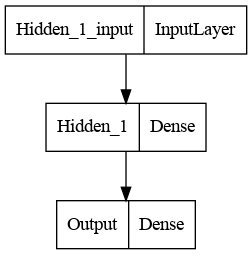

In [21]:
# Create a Sequential model
model = Sequential(name='seq_model_strike')

# Add an input layer and a hidden layer with 10 neurons
model.add(Dense(num_units_dense_1, input_shape=(num_inputs,)
                ,activation=activ_dense, name='Hidden_1'))

# Add a 1-neuron output layer
model.add(Dense(num_outputs, activation=activ_output, name='Output'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='adam'
              ,metrics=['accuracy']
             )

# Summarise your model
model.summary()

plot_model(model)

In [22]:
f"To keep it realtively simple, we chose to use {num_units_dense_1} nodes in 1 hidden layer."

'To keep it realtively simple, we chose to use 2 nodes in 1 hidden layer.'

---

#### Model training

We will save the model `History`.

In [23]:
# Train model
mod_hist =  model.fit(X_train, y_train, epochs = n_epochs
                        ,validation_split=val_split)

Epoch 1/2
7897/7897 [==============================] - 8s 970us/step - loss: 0.6149 - accuracy: 0.6741 - val_loss: 0.5698 - val_accuracy: 0.6876
Epoch 2/2
7897/7897 [==============================] - 8s 965us/step - loss: 0.5371 - accuracy: 0.6980 - val_loss: 0.4977 - val_accuracy: 0.7343


Not too bad through 2 epochs. Kind of weird that train accuracy is lower than validation accuracy, but we won't worry too much about it right now; only if we keep seeing it consistently in subsequent runs/tuning.

Let's convert the history to a `DataFrame` for easier manipulation.

In [24]:
df_mod_history = (pd.DataFrame(mod_hist.history).reset_index()
                  .rename(columns={'index': 'epoch', 'loss': 'train_loss'
                                   ,'accuracy': 'train_accuracy'}) 
                 )

In [25]:
df_mod_history

,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,0,0.614945,0.674107,0.569846,0.687645
1,1,0.537072,0.698049,0.497707,0.734266


Let's do a quick viz on the accuracy over the two epochs.

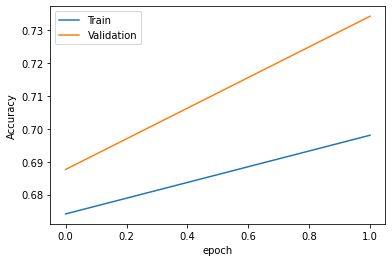

In [26]:
_ = sns.lineplot(data=df_mod_history, x='epoch', y='train_accuracy')
_ = sns.lineplot(data=df_mod_history, x='epoch', y='val_accuracy')
# _.set(ylim=(min_y,1))
_.set_ylabel("Accuracy")
plt.legend(labels=["Train","Validation"])
plt.show()

Let's evaluate the model on the *test* set.

In [27]:
# Evaluate model accuracy on the test set
accuracy = model.evaluate(X_test, y_test)[1]

# Print accuracy
print('Accuracy:', accuracy)

2194/2194 [==============================] - 2s 699us/step - loss: 0.4994 - accuracy: 0.7344
Accuracy: 0.7343571782112122


Test accuracy of .74 is in line with what we saw out of train/val (.72/0.75).

Now that we created a single model as a warmup, let's try to hone in on a good candidate using Random Hyperparameter Search.

---  

<span style="font-size:0.5em;">Tag 3</span>

### Random Hyperparameter Search<a id='random_search'></a>

<span style="font-size:0.5em;"><a href='#toc_4'>Back to TOC</a></span>

#### Preparation

Let's create functions for:
- Model build

In reviewing methodology to use `keras` with `sklearn`, I found `scikeras`. Their [tutorial](https://www.adriangb.com/scikeras/stable/notebooks/Basic_Usage.html#4.2-Saving-using-Keras-saving-methods) has a lot of good examples on how to leverage `sklearn` functionality but use Keras models, so alot of the following will be leveraging those example codes.

Create model build function to create a binary classification neural network model that ingests the current set of parameters.

In [27]:
# Full credit to scikeras tutorial (see 2.2 in 'tutorial' link above)
def get_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    return model

Instantiate a `scikeras` classifier:

In [29]:
clf = KerasClassifier(
    model=get_clf,
    loss="binary_crossentropy",
    optimizer="adam",
    optimizer__lr=0.1,
    model__hidden_layer_sizes=(100,),
    model__dropout=0.5,
    verbose=True,
    metrics=['binary_accuracy'],
    validation_split=0.10
)

# clf.fit(X_train, y_train)

Let's create a grid of parameters and do a random search to identify the most promising combination.


Create `dict` of parameters to perform random search on.

In [30]:
params = {
    'optimizer__lr': [0.001, 0.01, 0.05, 0.5],
    'model__hidden_layer_sizes': [(100,), (50, 50, )],
    'model__dropout': [0, 0.5],
    'epochs': [2, 3, 5],
    'batch_size': [32, 128, 256]
}

Instantiate the `RandomSearchCV` object:

In [31]:
rs = RandomizedSearchCV(estimator=clf
                        ,param_distributions=params
                        ,cv=5
                        ,refit=True
                        ,verbose=True
                        )

Fit to the training data!

In [32]:
rs_results = rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/3
1580/1580 [==============================] - 3s 1ms/step - loss: 0.1964 - binary_accuracy: 0.9135 - val_loss: 0.1741 - val_binary_accuracy: 0.9243
Epoch 2/3
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1759 - binary_accuracy: 0.9227 - val_loss: 0.1793 - val_binary_accuracy: 0.9213
Epoch 3/3
439/439 [==============================] - 0s 597us/step
Epoch 1/3
1580/1580 [==============================] - 3s 2ms/step - loss: 0.1949 - binary_accuracy: 0.9144 - val_loss: 0.1756 - val_binary_accuracy: 0.9246
Epoch 2/3
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1764 - binary_accuracy: 0.9230 - val_loss: 0.1840 - val_binary_accuracy: 0.9184
Epoch 3/3
439/439 [==============================] - 0s 589us/step
Epoch 1/3
1580/1580 [==============================] - 3s 2ms/step - loss: 0.1951 - binary_accuracy: 0.9145 - val_loss: 0.1784 - val_binary_accuracy: 0.9219
Epoch 2/3
1580/1580 

Ok, let's `pickle` the results for later reference if we can't complete our review right away.

In [33]:
str_ts = datetime.now().strftime("%Y%m%d_%H%M")
file_nm = 'nn_rs_2nd_pass_' + str_ts
file_path = './models/rs_results/' + file_nm + '.pickle'
# pred_path = './predictions/test/' + file_nm + '.csv'

display(file_path)

with open(file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_results, f, pickle.HIGHEST_PROTOCOL)

'./models/rs_results/nn_rs_2nd_pass_20220507_2122.pickle'

2022-05-07 21:22:29.131879: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram:///tmp/tmpomf_vhcy/assets


In [34]:
%%script echo skipping
str_ts = datetime.now().strftime("%Y%m%d_%H%M")
model_nm = 'nn_2nd_pass_' + str_ts
model_path = './models/' + model_nm
pred_path = './predictions/test/' + model_nm + '.csv'

display(model_path, pred_path)

# save out predicted probabilities
pred_curr = rs_best.predict_proba(X_test)
np.savetxt(pred_path, pred_curr, delimiter=",")

# Save out Keras model
rs_best.model_.save(model_path)

skipping


##### Reload results

In [36]:
#%%script echo skipping
# Test loading pickle
#load_path = './models/rs_results/classic_rs_1st_pass_20220505_1544.pickle'
load_path = './models/rs_results/nn_rs_2nd_pass_20220507_2122.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_results = pickle.load(f)

#### Results

Let's look at the best accuracy score, and the parameters that produced them.

In [37]:
display(rs_results.best_score_, rs_results.best_params_)

0.9306435542068405

{'optimizer__lr': 0.001,
 'model__hidden_layer_sizes': (100,),
 'model__dropout': 0,
 'epochs': 2,
 'batch_size': 32}

Let's look at it as an estimator object.

In [38]:
rs_best = rs_results.best_estimator_
display(rs_best)

KerasClassifier(
	model=<function get_clf at 0x7f5b4479e5e0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=['binary_accuracy']
	batch_size=32
	validation_batch_size=None
	verbose=True
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=2
	optimizer__lr=0.001
	model__hidden_layer_sizes=(100,)
	model__dropout=0
	class_weight=None
)

Let's look at a high level plot of the model, to make sure it makes sense vis a vis the best params.

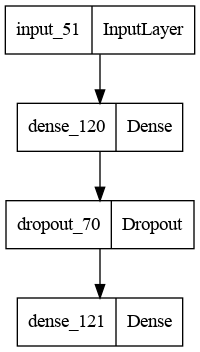

In [39]:
plot_model(rs_best.model_)

Look at summary:

In [40]:
rs_best.model_.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 100)               1400      
                                                                 
 dropout_70 (Dropout)        (None, 100)               0         
                                                                 
 dense_121 (Dense)           (None, 1)                 101       
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


Now let's look at performance vs Test.

In [41]:
display(f"test accuracy: {rs_best.score(X_test, y_test)}")
display(f"train accuracy: {rs_results.best_score_}")

2194/2194 [==============================] - 1s 621us/step


'test accuracy: 0.9288237975837702'

'train accuracy: 0.9306435542068405'

Consistent, and aligns.

Let's get some predictions and review some high level classification metrics:

In [42]:
rs_pred = rs_best.predict(X_test)

2194/2194 [==============================] - 1s 608us/step


*Confusion Matrix*

In [43]:
cm = confusion_matrix(y_test, rs_pred)
display(cm)

array([[45918,  2294],
       [ 2702, 19278]])

*Accuracy*

In [44]:
display("What % of pitches did we correctly categorize?")
display(f"test accuracy: {round(rs_best.score(X_test, y_test), 3)}")

'What % of pitches did we correctly categorize?'

2194/2194 [==============================] - 1s 610us/step


'test accuracy: 0.929'

*Precision*

In [45]:
precision = precision_score(y_test, rs_pred)
display("What % predicted strikes did we get correct?")
display(f"Positive Predictive Value: {round(precision,3)}")

'What % predicted strikes did we get correct?'

'Positive Predictive Value: 0.894'

*Recall*

In [46]:
recall = recall_score(y_test, rs_pred)
display("What percent of actual strikes did we get capture?")
display(f"True Positive Rate: {round(recall, 3)}")

'What percent of actual strikes did we get capture?'

'True Positive Rate: 0.877'

*ROC/AUC*

2194/2194 [==============================] - 1s 620us/step


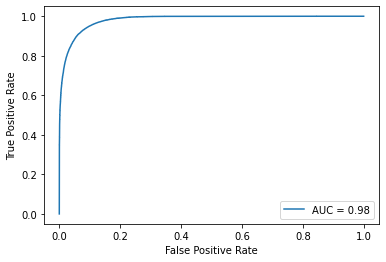

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, rs_best.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

Again, AUC of 0.98! This is really good, considering rough rule of thumb is >0.85 is a good performing classifier.

*Save the current state*

Let's save out the best model!

In [48]:
str_ts = datetime.now().strftime("%Y%m%d_%H%M")
model_nm = 'nn_2nd_pass_' + str_ts
model_path = './models/' + model_nm
pred_path = './predictions/test/' + model_nm + '.csv'

display(model_path, pred_path)

# save out predicted probabilities
pred_curr = rs_best.predict_proba(X_test)
np.savetxt(pred_path, pred_curr, delimiter=",")

# Save out Keras model
rs_best.model_.save(model_path)

'./models/nn_2nd_pass_20220507_2134'

'./predictions/test/nn_2nd_pass_20220507_2134.csv'

2194/2194 [==============================] - 1s 627us/step
INFO:tensorflow:Assets written to: ./models/nn_2nd_pass_20220507_2134/assets


---  
<span style="font-size:0.5em;">Tag 4</span>

### Summary <a id='summary'></a>

<span style="font-size:0.5em;"><a href='#toc_4'>Back to TOC</a></span>

<span style="color:blue">
Our metric of choice is Accuracy, and the best model found by the random search over 10 iterations had a:

- training accuracy of **0.930**
- test accuracy was **0.929** as well

Other classification metrics for context are:
- Precision/Positive Predictive Value: **0.894**
- Recall/True Positive Rate: **0.877**
- ROC AUC: **0.98**
</span>

<span style="color:blue">  
All these metrics I would consider to be very good performance, contigent on specific use case of ultimate customer(s). For example a requirement might that the customer might want to maximize PPV as much as possible and would like to target >0.90.
</span>

<span style="color:blue">
Compare this to the first run, before the addition of 8 more features:
</span>

<span style="color:dodgerblue">  
    
- training accuracy of **0.928**  
- test accuracy was **0.928** as well

Other classification metrics for context are:
- Precision/Positive Predictive Value: **0.888**
- Recall/True Positive Rate: **0.881**
- ROC AUC: **0.98**
</span>

<span style="color:blue">
2nd run improved on the original runs very slightly, across the board for the most part (with the exception of Recall, rate; BUT we're talking about a difference in the hundredths).
    
**So is it worth it to add these features? I think on balance it is.** 
    
My reasoning is that I consider the addition of them:

- `bside`
- `pside`
- `break_x`
- `break_z`
- `angle_x`
- `angle_z`
- `pitch_speed`
        
...to be 'costless', on the assumption that whatever process captures the original features that were used in the first run also 'simultaneously' capture these additional features; so no substantial extra effort is required to gather the data.
</span>

---  
<span style="font-size:0.5em;">Tag 5</span>

### Wrap Up Neural Network <a id='wrap'></a>

<span style="font-size:0.5em;"><a href='#toc_4'>Back to TOC</a></span>

In [107]:
%%script echo skipping

#load_path = './models/rs_results/classic_rs_1st_pass_20220505_1544.pickle'
load_path = './models/rs_results/nn_rs_2nd_pass_20220507_2122.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_results = pickle.load(f)

skipping


In [29]:
rs_results.best_estimator_

KerasClassifier(
	model=<function get_clf at 0x7fa2dd1815e0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=['binary_accuracy']
	batch_size=32
	validation_batch_size=None
	verbose=True
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=2
	optimizer__lr=0.001
	model__hidden_layer_sizes=(100,)
	model__dropout=0
	class_weight=None
)

In [33]:
rs_results.best_params_

{'optimizer__lr': 0.001,
 'model__hidden_layer_sizes': (100,),
 'model__dropout': 0,
 'epochs': 2,
 'batch_size': 32}

In [108]:
rs_best = rs_results.best_estimator_

Confirm that the paramaters match to the above dictionary of `best_params_`

In [109]:
rs_best.get_params

<bound method BaseEstimator.get_params of KerasClassifier(
	model=<function get_clf at 0x7fa2dd1815e0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=['binary_accuracy']
	batch_size=32
	validation_batch_size=None
	verbose=True
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=2
	optimizer__lr=0.001
	model__hidden_layer_sizes=(100,)
	model__dropout=0
	class_weight=None
)>

In [57]:
# Train model
mod_hist_final =  rs_best.fit(X_train, y_train)

Epoch 1/2
7897/7897 [==============================] - 11s 1ms/step - loss: 0.1914 - binary_accuracy: 0.9171 - val_loss: 0.1637 - val_binary_accuracy: 0.9286
Epoch 2/2
7897/7897 [==============================] - 10s 1ms/step - loss: 0.1603 - binary_accuracy: 0.9302 - val_loss: 0.1614 - val_binary_accuracy: 0.9292


In [60]:
df_res_final = (pd.DataFrame(mod_hist_final.history_).reset_index()
                  .rename(columns={'index': 'epoch', 'loss': 'train_loss'
                                   ,'accuracy': 'train_accuracy'}) 
                 )

In [61]:
df_res_final

,epoch,train_loss,binary_accuracy,val_loss,val_binary_accuracy
0,0,0.191443,0.917100,0.163725,0.928554
1,1,0.160331,0.930231,0.161355,0.929159


Within 2 epochs we see that the validation and training loss had stabled off. 

**Is 2 epochs enough?** 
In this case I would say it's sufficient. In the random search there were parameter combos that had >2 epochs that didn't perform as well. Here are the top 10 by `mean_test_score`

In [70]:
df_res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_optimizer__lr', 'param_model__hidden_layer_sizes',
       'param_model__dropout', 'param_epochs', 'param_batch_size', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [71]:
df_res = pd.DataFrame(rs_results.cv_results_)

df_res[['rank_test_score', 'mean_test_score', 'param_epochs', 'param_batch_size'
        ,'param_optimizer__lr', 'param_model__hidden_layer_sizes', 'param_model__dropout']].sort_values(['mean_test_score'], ascending=False)

,rank_test_score,mean_test_score,param_epochs,param_batch_size,param_optimizer__lr,param_model__hidden_layer_sizes,param_model__dropout
8,1,0.930644,2,32,0.001,"(100,)",0
4,2,0.930351,3,128,0.001,"(50, 50)",0
3,3,0.928521,2,32,0.001,"(50, 50)",0.5
1,4,0.927288,5,128,0.01,"(100,)",0
9,5,0.926612,2,128,0.01,"(100,)",0
2,6,0.926359,2,128,0.05,"(100,)",0
0,7,0.926110,3,128,0.05,"(100,)",0
5,8,0.899888,5,128,0.05,"(50, 50)",0.5
7,9,0.686865,3,32,0.5,"(50, 50)",0.5
6,10,0.686811,3,32,0.5,"(100,)",0.5


And note by quick visual inspection that the performance appears to be very comparable across the top 7 models.

Let's take a quick look at permuation importance to see if it aligns with our intution.

In [78]:
nn_pi = permutation_importance(rs_best, X_train, y_train
                                ,n_repeats=10
                                ,n_jobs=-1
                                ,random_state=random_state)


8774/8774 [==============================] - 6s 640us/step


2022-05-10 21:52:28.681154: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram:///tmp/tmppwo13whe/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpiy52leq3/assets


2022-05-10 21:52:29.794357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 21:52:29.794385: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


INFO:tensorflow:Assets written to: ram:///tmp/tmp30fo1gfb/assets


2022-05-10 21:52:30.279134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 21:52:30.279169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-10 21:52:31.506110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-10 21:52:31.506146: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-10 21:52:31.506165: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4613f88c-df71-4f14-9f0a-e1096ce8e62e): /proc/driver/nvidia/version does not exist
2022-05-10 21:52:31.506365: I tensorflow

8774/8774 [==============================] - 9s 974us/step
INFO:tensorflow:Assets written to: ram:///tmp/tmpgw9bv3ak/assets
8774/8774 [==============================] - 6s 639us/step


In [84]:
nn_pi.importances_mean

array([0.00511919, 0.0178137 , 0.23704353, 0.00148023, 0.00061332,
       0.21830343, 0.00555122, 0.00056453, 0.0094858 , 0.0120641 ,
       0.01447962, 0.02773154, 0.02885631])

In [87]:
for i in nn_pi.importances_mean.argsort()[::-1]:
     if nn_pi.importances_mean[i] - 2 * nn_pi.importances_std[i] > 0:
         print(f"{df_X.columns[i]:<8}"
               f"{nn_pi.importances_mean[i]:.3f}"
               f" +/- {nn_pi.importances_std[i]:.3f}")

pz      0.237 +/- 0.001
px      0.218 +/- 0.001
pside_R 0.029 +/- 0.000
pside_L 0.028 +/- 0.000
angle_x 0.018 +/- 0.000
bside_R 0.014 +/- 0.000
bside_L 0.012 +/- 0.000
angle_z 0.009 +/- 0.000
break_z 0.006 +/- 0.000
break_x 0.005 +/- 0.000
stringer_zone_top0.001 +/- 0.000
stringer_zone_bottom0.001 +/- 0.000
pitch_speed0.001 +/- 0.000


Here, we see that the `location` has the largest importance, which makes intuitive sense. 

In the XGB to be fitted in [notebook 6](06_improved_non_nn_model.ipynb) we see that the top 2 are the same using feature importance, but pitching side and batting side fall way to the bottom. I'm wondering if that has to do with their binarized nature, if given the chance perhaps we should drop one of the OHE columns? This also reminds us that importance metrics should always be taken with a grain of informative salt as they should be viewed in that they are important ONLY to the very singular model it was measured on!

Having said that, I'm good with recommending the best model for implementation.

Let's designate our chosen model.

In [93]:
# This was the best model from our RandomSearch
selected_model = rs_best

#### Make Predictions on Holdout

##### Predicted Classes

In [94]:
pred_classes = selected_model.predict(holdout_scaled)
display(pred_classes.shape)

583/583 [==============================] - 0s 627us/step


(18633,)

Quick look at results:

In [95]:
pred_classes[:100]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [98]:
sum(pred_classes)

5495

Look at relative ratio of strikes:

In [96]:
df_pred = pd.DataFrame(pred_classes)
df_pred.value_counts(normalize=True)

0    0.705093
1    0.294907
dtype: float64

For comparison, relative ratio in training data:

In [97]:
df_y.value_counts(normalize=True)

0    0.686864
1    0.313136
Name: strike_bool, dtype: float64

Fairly close! It could be a _dangerous_ assumption, but based on what we DO know of how the datasets were constructed, the fact that the ratios are so close makes me feel that our results are pretty good.

##### Predicted Probabilities

In [99]:
pred_proba = selected_model.predict_proba(holdout_scaled)

583/583 [==============================] - 0s 641us/step


Quick look at results:

In [100]:
np.round(pred_proba[:20], 3)

array([[0.999, 0.001],
       [1.   , 0.   ],
       [0.004, 0.996],
       [0.185, 0.815],
       [0.001, 0.999],
       [0.999, 0.001],
       [0.03 , 0.97 ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.99 , 0.01 ],
       [0.03 , 0.97 ],
       [0.02 , 0.98 ],
       [0.513, 0.487],
       [1.   , 0.   ],
       [0.988, 0.012],
       [0.648, 0.352],
       [0.384, 0.616],
       [0.995, 0.005],
       [1.   , 0.   ],
       [0.047, 0.953]], dtype=float32)

In [101]:
pred_proba_strike_only = pred_proba[:, -1]

In [104]:
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")
file_class_nm = 'nn_pred_vals_' + str_ts
file_proba_nm = 'nn_pred_proba_' + str_ts
file_proba_stk_nm = 'nn_pred_proba_strike_only_' + str_ts

file_class_path = './predictions/holdout/' + file_class_nm + '.csv'
file_proba_path = './predictions/holdout/' + file_proba_nm + '.csv'
file_proba_stk_path = './predictions/holdout/' + file_proba_stk_nm + '.csv'

display(file_class_path)
display(file_proba_path)
display(file_proba_stk_path)

'./predictions/holdout/nn_pred_vals_20220510_1516.csv'

'./predictions/holdout/nn_pred_proba_20220510_1516.csv'

'./predictions/holdout/nn_pred_proba_strike_only_20220510_1516.csv'

In [105]:
# save out predicted probabilities
np.savetxt(file_class_path, pred_classes, delimiter=",")
np.savetxt(file_proba_path, pred_proba, delimiter=",")
np.savetxt(file_proba_stk_path, pred_proba_strike_only, delimiter=",")

---  
<span style="font-size:0.5em;">Tag X</span>
<a id='the_end_4'></a>

<span style="font-size:0.5em;"><a href='#toc_4'>Back to TOC</a></span>

Next, let's repeat the exercise of adding the new features to the 'classical' model.